## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conc)



<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [194]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [195]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [196]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [197]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [198]:
(df[df.converted ==1]['converted'].count())/df.shape[0]


0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [199]:
old_treat = df.query("group == 'treatment' and landing_page == 'old_page' ").count()[0]
new_cont = df.query("group == 'control' and landing_page == 'new_page' ").count()[0]
old_treat + new_cont


3893

f. Do any of the rows have missing values?

In [201]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


***No missing values ***

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [202]:
grp1 = df.query("landing_page == 'new_page' & group == 'control'")
grp2 = df.query("landing_page == 'old_page' & group == 'treatment'")

In [203]:
df2 = df.copy()
df2.drop(grp1.index.values, inplace=True)
df2.drop(grp2.index.values, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [204]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [205]:
df2.nunique()[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [206]:
df2[df2.duplicated(('user_id'))]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [207]:
df2[df2.duplicated(('user_id'))]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [209]:
df2['user_id'].drop_duplicates(inplace = True)


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [210]:
(df2.query(" converted == '1'").count()/df2['converted'].count())['converted']

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [211]:
(df2.query(" converted == '1' & group == 'control'" ).count()/df2.query(" group == 'control' ").count())[4]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [212]:
(df2.query(" converted == '1' & group == 'treatment'" ).count()/df2.query(" group == 'treatment' ").count())[4]

0.11880724790277405

d. What is the probability that an individual received the new page?

In [213]:
(df2.query(" landing_page == 'new_page'").count()/df2.shape[0])[0]

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**As we saw in the previous results ,  the probability of receiving the new page is 50% . In addition , the probability of converting is too low to be relatively certain of the dataset . it still needs more interpretation .
That's why we need further analysis to get a sufficient answer to our question ..**



<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: $$  $$p_{old} <= p_{new}$$$
$$H_1: $$  $$p_{old} > p_{new}$









`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [214]:
p_new = df2['converted'].mean()
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [215]:
p_old = df['converted'].mean()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [217]:
n_new = df2.query("group == 'treatment'").count()[0]
n_new


145311

d. What is $n_{old}$, the number of individuals in the control group?

In [218]:
n_old = df2.query("group == 'control'").count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [219]:
new_page_converted = np.random.binomial(1, p_new , n_new)
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [220]:
old_page_converted = np.random.binomial(1, p_old , n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [221]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0027912788544653261

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [222]:
#Simulating 10000 p_diffs
p_diffs = [] 
for _ in range(10000): 
    n_page_converted = np.random.choice([1,0], size = n_new, p = (p_new, 1 - p_new)).mean() 
    o_page_converted = np.random.choice([1,0], size = n_old, p = (p_old, 1 - p_old)).mean() 
    diffs = n_page_converted.mean() - o_page_converted.mean() 
    p_diffs.append(diffs) 
p_diffs = np.array(p_diffs) 
p_diffs


array([ 0.00091244, -0.00100768,  0.00067841, ...,  0.0010847 ,
        0.00073356, -0.00067758])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

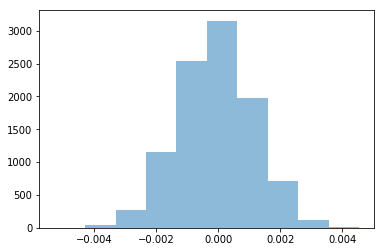

In [223]:
#Plotting p_diffs
plt.hist(p_diffs,alpha = 0.5 ) ;

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [224]:
(p_diffs > diff).mean()

0.0080000000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.** What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

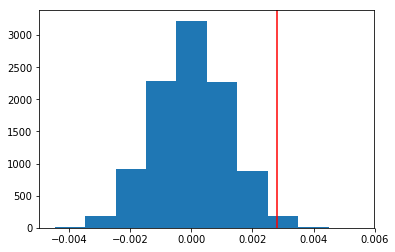

In [225]:
#simulation and plotting the null 
null_vals = np.random.normal(0, p_diffs.std() ,p_diffs.size )
plt.hist(null_vals)
plt.axvline(x=diff ,color = 'r' ) ;

**What i computed in part j is called p_value . This value means that even when we replacedthe population with a sample we still have statistic values from the null.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [226]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new =df2.query("landing_page == 'new_page' and converted == 1").shape[0] 
n_old = df2.shape[0] - df2.query("landing_page == 'new_page'").shape[0]
n_new =df2.query("landing_page == 'new_page'").shape[0]
 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [227]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value is almost equal to the one computed in section J. All the results are consistent with the findings in sections J and K.
the z-score of 1.31 is less than the critical value of 95% confidence level.we conclude that new page does not increase conversion rate . Hence, we fail to reject the null hypothesis. .**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should perform Logistic Regression in this case .**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [228]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['control']



In [229]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [230]:
logim = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logim.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [231]:
results.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 13:31 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1467  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3116  0.1897  -0.0074   0.0374
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**$$H_0: $$  $$p_{old} = p_{new}$$$
$$H_1: $$  $$p_{old} != p_{new}$$$
$$In this Logistic regression model we performed a two tailed test
both  methods say that we fail to reject the null.we conclude that the new page does not change the conversion rate . So our regression model conforms to the conclusions from previous methods.**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding a relevant variable can prevent bias in the estimate of the other regression coefficient but can also increase the variance of other regression coefficients.**

**Adding an irrelevant variable can increase the variance of the estimate of other correlation coefficients and will not have any benefits.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [232]:
countries = pd.read_csv('countries.csv')


In [233]:
merged_df = pd.merge(df2 , countries , on='user_id')
merged_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,US


In [234]:
merged_df['US_ab_page'] = pd.get_dummies(merged_df['country'])['US']
merged_df['UK_ab_page'] = pd.get_dummies(merged_df['country'])['UK']



In [235]:
model = sm.Logit(merged_df['converted'],merged_df[['intercept','ab_page','US_ab_page','UK_ab_page']])
result= model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 13:31 AIC:              212781.3782
No. Observations:   290585           BIC:              212823.6968
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0450    0.0266  -76.8198  0.0000  -2.0972  -1.9928
ab_page        0.0150    0.0114    1.3076  0.1910  -0.0075   0.0374
US_ab_page     0.0408    0.0269    1.5159  0.1296  -0.0119   0.0934
UK_ab_page     0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

**No significant p-value because all the values are higher than 0.05 even after adding the countries .
 As a result we fail to reject the NULL Hypothesis again .***

h. 

In [236]:
merged_df[['ca', 'uk', 'us']] = pd.get_dummies(merged_df['country'])

In [237]:
 ## We first consider us and ca
logit1 = sm.Logit(merged_df['converted'],merged_df[['intercept','us','ca']]).fit()
logit1.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 13:31 AIC:              212781.0880
No. Observations:   290585           BIC:              212812.8269
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
us           -0.0099    0.0133    -0.7462  0.4555  -0.0360   0.0161
ca           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
==================================================================

"""

In [238]:
## now we consider uk and ca
logit2 = sm.Logit(merged_df['converted'],merged_df[['intercept','uk','ca']]).fit() 
logit2.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 13:31 AIC:              212781.0880
No. Observations:   290585           BIC:              212812.8269
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3154  0.0000  -2.0101  -1.9833
uk            0.0099    0.0133     0.7462  0.4555  -0.0161   0.0360
ca           -0.0408    0.0269    -1.5176  0.1291  -0.0935   0.0119
==================================================================

"""

In [239]:
## now we consider uk and us
logit3 = sm.Logit(merged_df['converted'],merged_df[['intercept','uk','us']]).fit() 
logit3.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-30 13:31 AIC:              212781.0880
No. Observations:   290585           BIC:              212812.8269
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
uk             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
us             0.0408    0.0269    1.5176  0.1291  -0.0119   0.0935
==================================================================

"""

***In each case , we tried to interact the countries with converted users values . Thus, we can interpret that there are no interactions between page and country and have no major effects on conversion.***

<a id='conc'></a>
### Conclusion

The null and alternative hypothesis depend on what kind of A/B testing we are doing:

- In Part 2 of the project, we are performing a one-tailed test.

- In Part 3, we are performing a two-tailed test.

One-tailed test is more concerned about the change in a particular direction 
(in our case, increase in conversion when moving from old page to new page in Part 2 of the project),
 where as the two-tailed test 
is just about the change in any direction ( the reason for the "not-equal-to" sign in Part 3 ).

In [240]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0